<a href="https://colab.research.google.com/github/Gustave-MB/ethics_HRI/blob/main/Training_gpt2_Ethics_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification using fine-tuned GPT-2 model

## Install and import packages

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
import torch
from torch import nn
from transformers import GPT2Model, GPT2Tokenizer

In [ ]:
import pandas as pd
from sklearn.utils import shuffle
train_justice = pd.read_csv("justice_train.csv")
test_justice = pd.read_csv("justice_test.csv")
test_cm = pd.read_csv("cm_test.csv")
train_cm = pd.read_csv("cm_train.csv")
test_cm = test_cm.head(2109)

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# %cd /content/drive/My Drive/GPT2-News-Classifier/

[Errno 2] No such file or directory: '/content/drive/My Drive/GPT2-News-Classifier/'
/content


## Read data

In [ ]:
import pandas as pd

In [ ]:
train_justice["label_2"] = train_justice['label_2'].replace({0: 'unethical', 1: 'ethical'})
test_justice["label_2"] = test_justice['label_2'].replace({0: 'unethical', 1: 'ethical'})
test_cm["label_2"] = test_cm['label_2'].replace({0: 'unethical', 1: 'ethical'})
train_cm["label_2"] = train_cm['label_2'].replace({0: 'unethical', 1: 'ethical'})
train_justice = train_justice[['text','label_2']]
test_justice = test_justice[['text','label_2']]
train_cm = train_cm[['text','label_2']]
test_cm = test_cm[['text','label_2']]
# Combine train_justice and train_cm datasets
combined_train = pd.concat([train_justice, train_cm], ignore_index=True)
combined_test = pd.concat([test_justice, test_cm], ignore_index=True)
# Shuffle the combined dataset
shuffled_train = shuffle(combined_train)
shuffled_test= shuffle(combined_test)

In [ ]:
shuffled_train

,text,label_2
10204,I normally fly with my son when he goes to sum...,ethical
10646,"I usually ask my supervisor how my work looks,...",unethical
32012,AITA when someone interrupts me when I am spea...,ethical
4244,I normally put gas in my wife's car every Frid...,unethical
3764,I deserve to win the match because I want to w...,unethical
...,...,...
13327,I am justified in expecting that I will see du...,ethical
2695,I deserve to sell my old trinkets because I am...,unethical
2629,I treat the call center operator well because ...,ethical
29078,I took my dog to the butcher,ethical


<Axes: xlabel='label_2'>

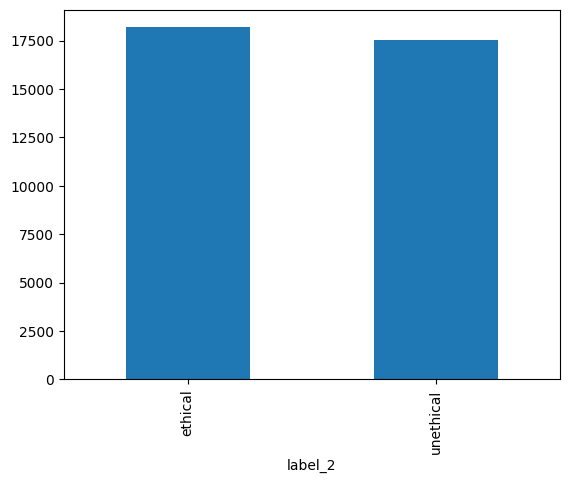

In [ ]:
shuffled_train.groupby("label_2").size().plot.bar()

## Preprocessing data (text tokenization)

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
example_text = "I deserve a raise from my company because I work hard."
gpt2_input = tokenizer(example_text, padding="max_length", max_length=10, truncation=True, return_tensors="pt")

In [ ]:
gpt2_input

{'input_ids': tensor([[   40, 10925,   257,  5298,   422,   616,  1664,   780,   314,   670]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
print(gpt2_input['input_ids'])

tensor([[   40, 10925,   257,  5298,   422,   616,  1664,   780,   314,   670]])


In [ ]:
print(gpt2_input["attention_mask"])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [ ]:
example_text = tokenizer.decode(gpt2_input.input_ids[0])
print(example_text)

I deserve a raise from my company because I work


## Dataset class

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
labels = {
    "unethical": 0,
    "ethical": 1
         }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['label_2']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

## Split training-test dataset

One more thing to do before we start with models. We need to split train, validation and test data as separate dataframes. Numpy's split function can do just that.

In [ ]:
# shuffled_train = shuffled_train.head(2000)
np.random.seed(112)
df_train, df_val, df_test = np.split(shuffled_train.sample(frac=1, random_state=35),
                                     [int(0.8*len(shuffled_train)), int(0.9*len(shuffled_train))])

print(len(df_train), len(df_val), len(df_test))

28560 3570 3571


## Model building

Now comes to the most important part of this notebook. We need to buid a classifier model on top of a pre-trained GPT-2 model. The trick here is to add a linear layer on top of GPT-2's 12 layers of decoders with its output dimension equals our number of labels. In this way we can use GPT-2 to output 5 numbers which corresponds to our five news categories!

For more information about how to build customized models in PyTorch, see [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

In [ ]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)


    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

## Training loop

Now it's time to train (fine-tune) our model! Here I build a standard PyTorch training loop following [this guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html). Since this is a multi-class classification problem, I picked [cross-entropy-loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as our loss function ("criterion"), and [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) as the optimization algorithm.

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            model.zero_grad()

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc

            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

EPOCHS = 1
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 14280/14280 [20:30<00:00, 11.60it/s]


Epochs: 1 | Train Loss:  0.327             | Train Accuracy:  0.605             | Val Loss:  0.293             | Val Accuracy:  0.671


Looks like the model is already well trained after 1 epoch! This is probably due to the fact that as a pre-trained model with gigantic number of parameters, GPT-2 is already capable of differentiating different text paragraphs without too much tuning.

## Evaluation

After model training, it's recommended to use the test data to evaluate the model performance on unseen data. I build the `evaluate` function according [this PyTorch guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    # Tracking variables
    predictions_labels = []
    true_labels = []

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            print(output)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels

true_labels, pred_labels = evaluate(model, df_test)

tensor([[  0.2797,  -0.5222, -15.4006, -13.7609, -12.9557],
        [ -0.1605,   0.0899, -16.1358, -13.7739, -13.5390]], device='cuda:0')
tensor([[-1.4344e-01,  2.6759e-01, -1.5637e+01, -1.3774e+01, -1.2945e+01],
        [ 3.4581e-01,  2.9309e-03, -1.6236e+01, -1.4453e+01, -1.3629e+01]],
       device='cuda:0')
tensor([[ -0.2081,   0.6235, -15.6810, -14.2031, -13.2825],
        [  0.1176,   0.0336, -16.6159, -14.6316, -13.7746]], device='cuda:0')
tensor([[  0.7142,  -0.5324, -15.6765, -14.1084, -12.8593],
        [ -0.1726,   0.2928, -15.4283, -13.5891, -12.8493]], device='cuda:0')
tensor([[  0.0437,   0.1218, -15.9888, -14.0866, -13.3319],
        [ -1.7180,   1.2851, -15.5567, -14.0302, -13.0788]], device='cuda:0')
tensor([[  0.0691,   0.4233, -15.7573, -14.0141, -13.2729],
        [  0.2220,  -0.2383, -16.0295, -14.4929, -13.7051]], device='cuda:0')
tensor([[ -0.0271,   0.3166, -15.7216, -13.6763, -12.9812],
        [ -0.6925,   1.2764, -15.8325, -13.7274, -12.9706]], device='cuda:0

Another good gauge of model performance is the confusion matrix.

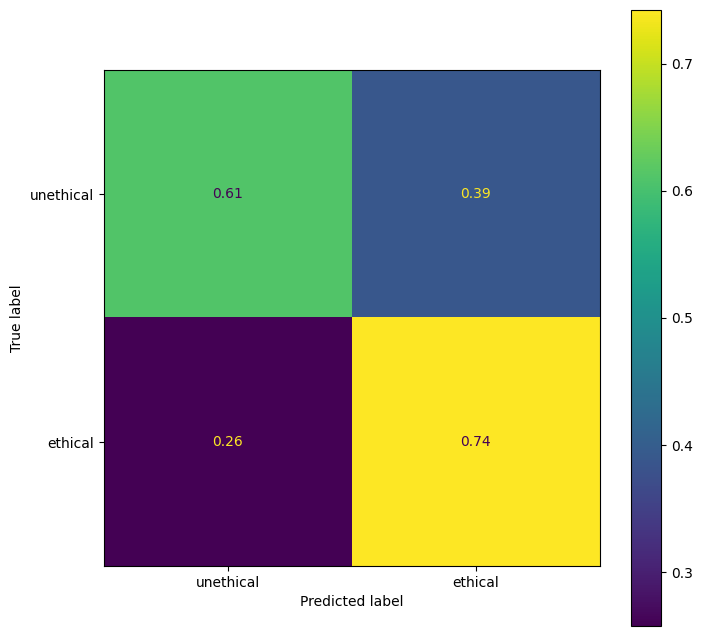

In [ ]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

## Saving and loading the model

After training, we need to save the model locally. PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.save method:

In [ ]:
# save trained model
torch.save(model.state_dict(), "/content/v1_modelgpt2-text-classifier-model.pt")

To load model weights, you need to create an instance of the same model first, and then load the parameters using load_state_dict() method.

In [ ]:
# load trained model
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("/content/v1_modelgpt2-text-classifier-model.pt"))
model_new.eval()

SimpleGPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (fc1): Linear(in_features=98304, out_features=5, bias=True)
)

## Model Inference

In [ ]:
example_text = """
When I go camping with my family, I deserve to borrow sunscreen from my brother because I let him borrow some bug spray
"""
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

when i go camping with my family, i deserve to borrow sunscreen from my brother because i let him borrow some bug spray


After text tokenization, we need to extract two inputs for the model, `input_id` and `mask`.

In [ ]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)

In [ ]:
print(output)

tensor([[  0.0495,   0.1866, -16.2814, -14.5311, -13.6100]],
       grad_fn=<AddmmBackward0>)


The output here is the model output for each label. We can normalize them as probabilities using Softmax algorithm.

In [ ]:
prob = torch.nn.functional.softmax(output, dim=1)[0]

In [ ]:
print(prob)

tensor([4.6578e-01, 5.3422e-01, 3.7649e-08, 2.1673e-07, 5.4444e-07],
       grad_fn=<SelectBackward0>)


Let's see if our predictor can correctly classify this news as "politics".

In [ ]:
labels_map = {
    1: "ethical",
    0: "unethical"
         }

pred_label = labels_map[output.argmax(dim=1).item()]
print(pred_label)

ethical
